In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import torch

from onnx_tf.backend import prepare
import onnx

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## Pytorch to ONNX

In [2]:
file_size = os.path.getsize('models/yolov8s.pt')
print("File Size is :", round(file_size/1024**2, 2), "mb")

File Size is : 21.53 mb


In [3]:
model = torch.load('models/yolov8s.pt')['model']
model.eval()
model.float()
model = model.fuse()

inputs = torch.randn(1, 3, 640, 640)
classes = model.names

torch.onnx.export(model,
                  inputs,
                  "models/onnx/float32.onnx",
                  verbose=False,
                  opset_version=14,
                  do_constant_folding=True,
                  input_names = ['images'],
                  output_names = ['output0'])

YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients


In [4]:
file_size = os.path.getsize('models/onnx/float32.onnx')
print("File Size is :", round(file_size/1024**2, 2), "mb")

File Size is : 42.61 mb


## ONNX to TensorFlow

In [5]:
onnx_model_path = 'models/onnx/float32.onnx'
saved_model_dir = 'models/tflite/saved_model'

onnx_model = onnx.load(onnx_model_path)
tf_rep = prepare(onnx_model)
tf_rep.export_graph(saved_model_dir)

INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_196_x, add_100_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/tflite/saved_model\assets


INFO:tensorflow:Assets written to: models/tflite/saved_model\assets
INFO:absl:Writing fingerprint to models/tflite/saved_model\fingerprint.pb


In [6]:
file_size = os.path.getsize('models/tflite/saved_model/saved_model.pb')
print("File Size is :", round(file_size/1024**2, 2), "mb")

File Size is : 43.81 mb


## TF to TFLite  < float32 >

In [7]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

print(f'File Size is: {round(open("models/tflite/float32.tflite", "wb").write(tflite_model)/1024**2,2)} mb')

File Size is: 42.78 mb


In [8]:
# weights and type

tflite_model_path = 'models/tflite/float32.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for layer in interpreter.get_tensor_details()[50:55]:
    layer_dtype = layer['dtype']
    if 'quantization' in layer:
        print(f"Data type: {layer_dtype}")
        print(interpreter.tensor(layer['index'])()[:5])

Data type: <class 'numpy.float32'>
[    -0.9451    -0.95379    -0.66006     -1.0628    -0.80914]
Data type: <class 'numpy.float32'>
[     3.9261     0.57977      1.6554      2.4048      5.7037]
Data type: <class 'numpy.float32'>
[    -5.2969     -9.6406     -8.9375       -9.25     -9.3594]
Data type: <class 'numpy.float32'>
[   -0.45149    -0.81915    -0.50871     0.53192    -0.45327]
Data type: <class 'numpy.float32'>
[     1.3225      2.2491      5.4748      1.9989      1.8714]


## TF to TFLite  < float16 >

In [9]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

print(f'File Size is: {round(open("models/tflite/float16.tflite", "wb").write(tflite_quant_model)/1024**2,2)} mb')

File Size is: 21.48 mb


In [10]:
# weights and type

tflite_model_path = 'models/tflite/float16.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for layer in interpreter.get_tensor_details()[50:55]:
    layer_dtype = layer['dtype']
    if 'quantization' in layer:
        print(f"Data type: {layer_dtype}")
        print(interpreter.tensor(layer['index'])()[:5])

Data type: <class 'numpy.int32'>
[-1]
Data type: <class 'numpy.float16'>
[     3.3223      1.6328      1.7715    -0.44409      2.6934]
Data type: <class 'numpy.float16'>
[     -1.623      2.8027      3.6113      1.7646     -3.2305]
Data type: <class 'numpy.float16'>
[     1.7715     0.52197      1.3506      1.3047      1.2461]
Data type: <class 'numpy.float16'>
[     1.1875      3.2168     -4.1094     0.20142     -1.2646]


## TF to TFLite  < int8 >

In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset():
    for _ in range(10):
        data = tf.random.uniform((1, 3, 640, 640), 0, 255)
        yield [data]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

print(f'File Size is: {round(open("models/tflite/int8.tflite", "wb").write(tflite_quant_model)/1024**2,2)} mb')

File Size is: 11.1 mb


In [12]:
# weights and type

tflite_model_path = 'models/tflite/int8.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for layer in interpreter.get_tensor_details()[55:65]:
    layer_dtype = layer['dtype']
    if 'quantization' in layer and layer_dtype==np.int8:
        print(f"Data type: {layer_dtype}")
        print(interpreter.tensor(layer['index'])()[0,0,0,:5])

Data type: <class 'numpy.int8'>
[ 7 -2  1  0  8]
Data type: <class 'numpy.int8'>
[  2  -6   7 -18  10]
Data type: <class 'numpy.int8'>
[ 0 30  7  9  2]
Data type: <class 'numpy.int8'>
[-5 76  6  4  5]
Data type: <class 'numpy.int8'>
[-2  2 -2 -2  0]


## Inference

In [13]:
# read model

interpreter = tf.lite.Interpreter(model_path="models/tflite/float32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

in_w, in_h = input_details['shape'][2:]

In [14]:
# read class names

model = torch.load('models/yolov8s.pt')['model']
classes = model.names

In [15]:
# Non-Maximum Suppression with data processing

def nms(data):
    data = data[0].T
    data = data[np.max(data[:, 4:], axis=1) > 0.3]
    
    boxes = data[:,:4]
    scores = np.max(data[:, 4:], axis=1)
    cls_idx = np.argmax(data[:, 4:], axis=1)
    
    boxes /= np.array([in_w, in_h, in_w, in_h])
    boxes *= np.array([im_w, im_h, im_w, im_h])

    boxes[:, 0] = boxes[:, 0] - boxes[:, 2]/2
    boxes[:, 1] = boxes[:, 1] - boxes[:, 3]/2
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= 0.3)[0]
        order = order[inds + 1]
        
    return boxes[keep], scores[keep], cls_idx[keep]

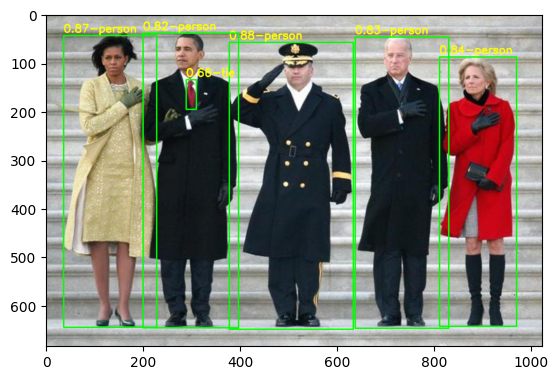

In [16]:
# image predict

image_path = 'images/test.jpg'
real_img = cv2.imread(image_path)
real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
im_h,im_w = real_img.shape[:2]
image = cv2.resize(real_img, (in_w,in_h))
image = np.expand_dims(np.transpose(image, (2, 0, 1)), 0)
image = image.astype(np.float32) / 255.

interpreter.set_tensor(input_details['index'], image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

boxes, scores, cls_idx = nms(output_data)

thresh = 0.5
for (box, score, idx) in zip(boxes, scores, cls_idx):
    if score > thresh:
        
        box = np.round(box).astype(np.int32).tolist()
        score = round(float(score), 2)

        cv2.rectangle(real_img, box[:2], box[2:], (0,255,0), 2)
        cv2.putText(real_img, str(score)+'-'+classes[idx], (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [255, 255, 0], thickness=2)
            
plt.imshow(real_img)
plt.show()

In [17]:
cap = cv2.VideoCapture("images/test.mp4")

if (cap.isOpened()== False):
    print("Error opening video file")

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        real_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_h,im_w = real_img.shape[:2]
        image = cv2.resize(real_img, (in_w,in_h))
        image = np.expand_dims(np.transpose(image, (2, 0, 1)), 0)
        image = image.astype(np.float32) / 255.

        interpreter.set_tensor(input_details['index'], image)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details['index'])
        boxes, scores, cls_idx = nms(output_data)

        thresh = 0.5
        for (box, score, idx) in zip(boxes, scores, cls_idx):
            if score > thresh:

                box = np.round(box).astype(np.int32).tolist()
                score = round(float(score), 2)

                cv2.rectangle(frame, box[:2], box[2:], (0,255,0), 2)
                cv2.putText(frame, str(score)+'-'+classes[idx], (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0, 255, 255], thickness=2)
        
        cv2.imshow('Frame', frame)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()